<a href="https://colab.research.google.com/github/NormLorenz/ai-llm-google-colab/blob/main/jupyter-notebooks/fine-tuning-day4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Product Pricer Continued

A model that can estimate how much something costs, from its description.

## Enter The Frontier!

And now - we put Frontier Models to the test.

### 2 important points:

It's important to appreciate that we aren't Training the frontier models. We're only providing them with the Test dataset to see how they perform. They don't gain the benefit of the 400,000 training examples that we provided to the Traditional ML models.

HAVING SAID THAT...

It's entirely possible that in their monstrously large training data, they've already been exposed to all the products in the training AND the test set. So there could be test "contamination" here which gives them an unfair advantage. We should keep that in mind.

In [1]:
!pip install datasets==3.6.0 gensim anthropic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.5/357.5 kB 17.3 MB/s eta 0:00:00
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0


In [2]:
# imports

import os
import re
import math
import json
import random
from dotenv import load_dotenv
from huggingface_hub import login
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter
from openai import OpenAI
from anthropic import Anthropic
from google.colab import userdata

In [3]:
# keys

openai_api_key = userdata.get("OPENAI_API_KEY")
claude_api_key = userdata.get("ANTHROPIC_API_KEY")
hugging_face_token = userdata.get("HF_TOKEN")

In [4]:
# initialize

os.environ['OPENAI_API_KEY'] = openai_api_key
os.environ['ANTHROPIC_API_KEY'] = claude_api_key
os.environ['HF_TOKEN'] = hugging_face_token

In [5]:
# Log in to HuggingFace

login(hugging_face_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [6]:
# get the python files from github

%%bash
wget https://raw.githubusercontent.com/NormLorenz/ai-llm-google-colab/main/jupyter-notebooks/items.py
wget https://raw.githubusercontent.com/NormLorenz/ai-llm-google-colab/main/jupyter-notebooks/loaders.py
wget https://raw.githubusercontent.com/NormLorenz/ai-llm-google-colab/main/jupyter-notebooks/testing.py
wget https://raw.githubusercontent.com/NormLorenz/ai-llm-google-colab/main/jupyter-notebooks/human_input.csv
wget https://raw.githubusercontent.com/NormLorenz/ai-llm-google-colab/main/jupyter-notebooks/human_output.csv

--2025-10-29 14:06:23--  https://raw.githubusercontent.com/NormLorenz/ai-llm-google-colab/main/jupyter-notebooks/items.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3760 (3.7K) [text/plain]
Saving to: ‘items.py’

     0K ...                                                   100% 44.1M=0s

2025-10-29 14:06:23 (44.1 MB/s) - ‘items.py’ saved [3760/3760]

--2025-10-29 14:06:23--  https://raw.githubusercontent.com/NormLorenz/ai-llm-google-colab/main/jupyter-notebooks/loaders.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2855 

In [7]:
# And some more imports - with thanks to Alex C for pointing out that I need to do these after the HF login..
# moved our Tester into a separate package
# call it with Tester.test(function_name, test_dataset)

from items import Item
from loaders import ItemLoader
from testing import Tester

tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

In [8]:
openai = OpenAI()
claude = Anthropic()

In [9]:
%matplotlib inline

In [10]:
# Mount your Google Drive at the beginning of the session
from google.colab import drive
drive.mount('/content/drive')

# Define the file path in your Google Drive
drive_path_one= '/content/drive/MyDrive/Colab Notebooks/train_lite.pkl'
drive_path_two= '/content/drive/MyDrive/Colab Notebooks/test_lite.pkl'

# Load the file
with open(drive_path_one, 'rb') as file:
    train = pickle.load(file)

# Load the file
with open(drive_path_two, 'rb') as file:
    test = pickle.load(file)

print("File loaded successfully:")

Mounted at /content/drive
File loaded successfully:


# Before we look at the Frontier

## There is one more model we could consider

In [11]:
# Write the test set to a CSV

import csv
with open('human_input.csv', 'w', encoding="utf-8") as csvfile:
    writer = csv.writer(csvfile)
    for t in test[:250]:
        writer.writerow([t.test_prompt(), 0])

In [12]:
# Read it back in

human_predictions = []
with open('human_output.csv', 'r', encoding="utf-8") as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        human_predictions.append(float(row[1]))

In [13]:
def human_pricer(item):
    idx = test.index(item)
    return human_predictions[idx]

In [ ]:
Tester.test(human_pricer, test)

## First, the humble but mighty GPT-4o-mini

It's called mini, but it packs a punch.

In [15]:
# First let's work on a good prompt for a Frontier model
# Notice that I'm removing the " to the nearest dollar"
# When we train our own models, we'll need to make the problem as easy as possible,
# but a Frontier model needs no such simplification.

def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

In [16]:
# Try this out

messages_for(test[0])

[{'role': 'system',
  'content': 'You estimate prices of items. Reply only with the price, no explanation'},
 {'role': 'user',
  'content': "How much does this cost?\n\nSetpower Insulated Protective Cover for AJ30 Portable Refrigerator Freezer, suitable for AJ30 Only\nInsulation & Waterproof well-made insulation could save battery power and improve cooling efficiency by preventing cold air from flowing away. Durable and Foldable with its oxford cloth outer layer, it's durable and protects your portable refrigerator from scratches and dust. Expanded Bag for Accessories two expanded bags on its side, expand space to store the other accessories. Great Ventilation a hollowed design for positions of vents doesn't affect the ventilation. Attention this insulated cover is ONLY suitable for SetPower AJ30 portable refrigerator. FIT TO AJ30 ONLY. Brand Name Setpower, Model Info AJ30 COVER, model number AJ30 COVER, Installation Type Freestanding, Part AJ30 cover, Special Features Portable, Color"

In [17]:
# A utility function to extract the price from a string

def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [18]:
get_price("The price is roughly $99.99 because blah blah")

99.99

In [19]:
# The function for gpt-4o-mini

def gpt_4o_mini(item):
    response = openai.chat.completions.create(
        model="gpt-4o-mini",
        messages=messages_for(item),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_price(reply)

In [20]:
test[0].price

65.99

1: Guess: $49.99 Truth: $65.99 Error: $16.00 SLE: 0.07 Item: Setpower Insulated Protective Cover for ...
2: Guess: $10.99 Truth: $9.68 Error: $1.31 SLE: 0.01 Item: TUAIC Refrigerator Door Light Switch 2 F...
3: Guess: $129.99 Truth: $155.98 Error: $25.99 SLE: 0.03 Item: Kegco Secondary Regulator, 3 Product, Ch...
4: Guess: $0.00 Truth: $5.59 Error: $5.59 SLE: 3.56 Item: MHY62044106 Refrigerator Door Spring 2Pc...
5: Guess: $30.00 Truth: $98.40 Error: $68.40 SLE: 1.36 Item: Ice-O-Matic 9131111-01 Float Valve
6: Guess: $35.99 Truth: $54.99 Error: $19.00 SLE: 0.17 Item: Wireless Temperature & Humidity Bluetoot...
7: Guess: $10.99 Truth: $5.71 Error: $5.28 SLE: 0.34 Item: 3Inch Thermometer Hygrometer for Indoor ...
8: Guess: $12.99 Truth: $9.53 Error: $3.46 SLE: 0.08 Item: GE WH1X2754 GE Timer Knob Assembly,white
9: Guess: $15.99 Truth: $11.24 Error: $4.75 SLE: 0.11 Item: newlifeapp 33001003 Dryer Lint Screen Fi...
10: Guess: $29.99 Truth: $12.88 Error: $17.11 SLE: 0.65 Item: Away NV350 NV

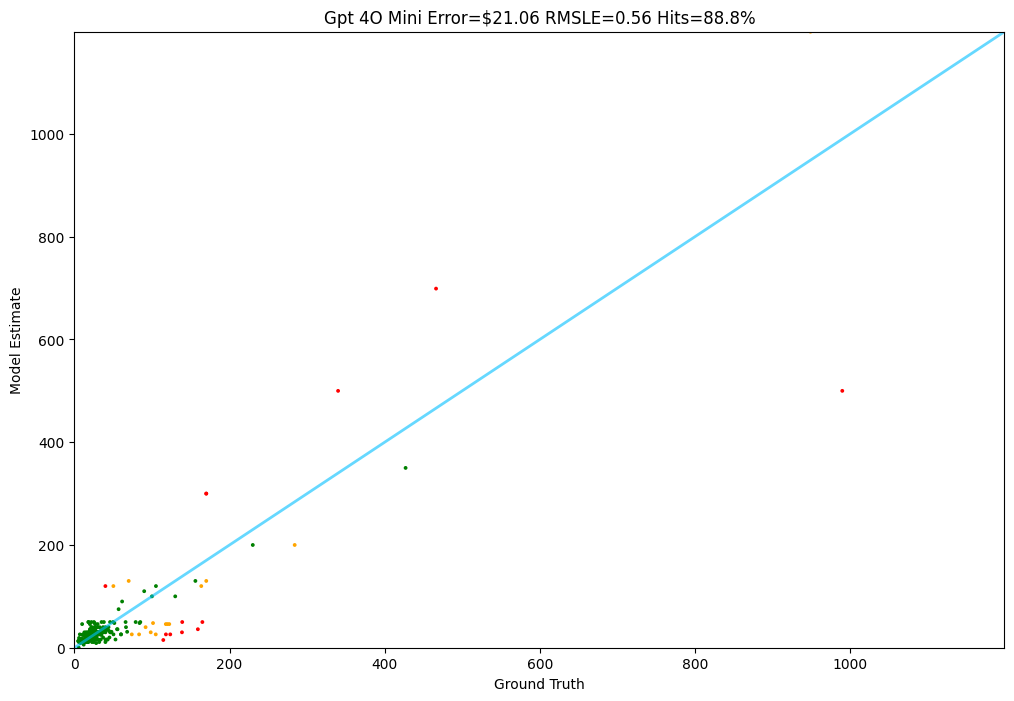

In [21]:
Tester.test(gpt_4o_mini, test)

In [ ]:
def gpt_4o_frontier(item):
    response = openai.chat.completions.create(
        model="gpt-4o-2024-08-06",
        messages=messages_for(item),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_price(reply)

In [ ]:
# The function for gpt-4o - the August model
# Note that it cost me about 1-2 cents to run this (pricing may vary by region)
# You can skip this and look at my results instead

Tester.test(gpt_4o_frontier, test)

In [22]:
def claude_3_point_7_sonnet(item):
    messages = messages_for(item)
    system_message = messages[0]['content']
    messages = messages[1:]
    response = claude.messages.create(
        model="claude-3-7-sonnet-latest",
        max_tokens=5,
        system=system_message,
        messages=messages
    )
    reply = response.content[0].text
    return get_price(reply)

/tmp/ipython-input-1361216691.py:5: DeprecationWarning: The model 'claude-3-7-sonnet-latest' is deprecated and will reach end-of-life on February 19th, 2026.
Please migrate to a newer model. Visit https://docs.anthropic.com/en/docs/resources/model-deprecations for more information.
  response = claude.messages.create(


1: Guess: $59.99 Truth: $65.99 Error: $6.00 SLE: 0.01 Item: Setpower Insulated Protective Cover for ...
2: Guess: $10.00 Truth: $9.68 Error: $0.32 SLE: 0.00 Item: TUAIC Refrigerator Door Light Switch 2 F...
3: Guess: $179.99 Truth: $155.98 Error: $24.01 SLE: 0.02 Item: Kegco Secondary Regulator, 3 Product, Ch...
4: Guess: $15.99 Truth: $5.59 Error: $10.40 SLE: 0.90 Item: MHY62044106 Refrigerator Door Spring 2Pc...
5: Guess: $24.99 Truth: $98.40 Error: $73.41 SLE: 1.80 Item: Ice-O-Matic 9131111-01 Float Valve
6: Guess: $24.99 Truth: $54.99 Error: $30.00 SLE: 0.59 Item: Wireless Temperature & Humidity Bluetoot...
7: Guess: $10.99 Truth: $5.71 Error: $5.28 SLE: 0.34 Item: 3Inch Thermometer Hygrometer for Indoor ...
8: Guess: $9.99 Truth: $9.53 Error: $0.46 SLE: 0.00 Item: GE WH1X2754 GE Timer Knob Assembly,white
9: Guess: $15.99 Truth: $11.24 Error: $4.75 SLE: 0.11 Item: newlifeapp 33001003 Dryer Lint Screen Fi...
10: Guess: $15.00 Truth: $12.88 Error: $2.12 SLE: 0.02 Item: Away NV350 NV3

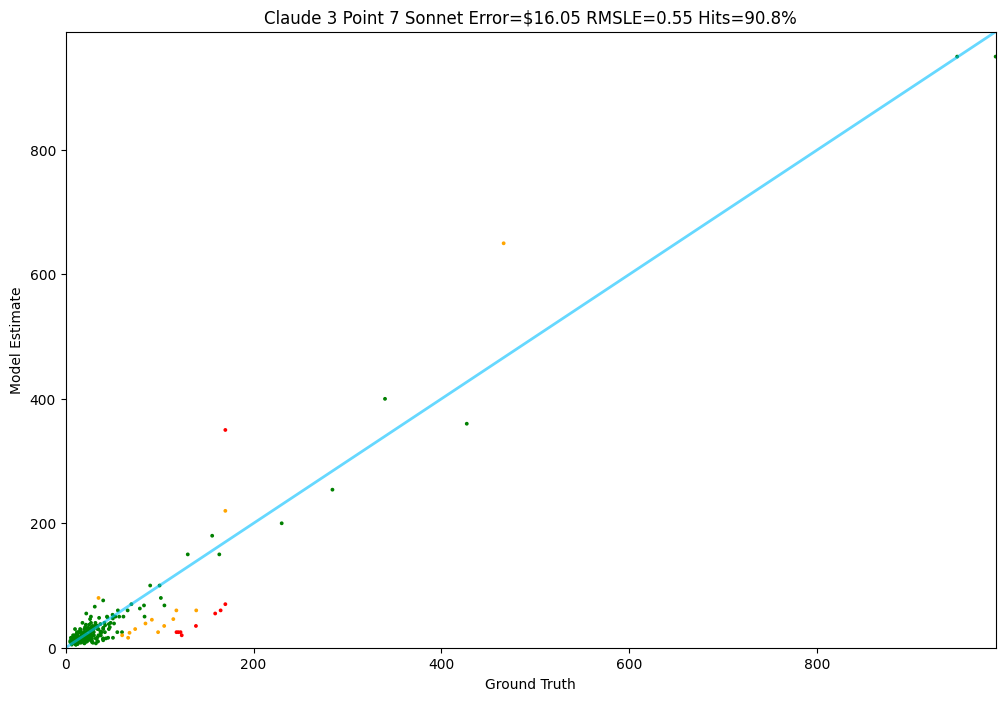

In [23]:
# The function for Claude 3.5 Sonnet
# It also cost me about 1-2 cents to run this (pricing may vary by region)
# You can skip this and look at my results instead

Tester.test(claude_3_point_7_sonnet, test)